<a href="https://colab.research.google.com/github/manthanawgan/MLops/blob/main/Duration_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error


In [3]:
pd.__version__

'2.2.2'

In [4]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")

In [5]:
df.shape

(3475226, 20)

In [6]:
df.dtypes

,0
VendorID,int32
tpep_pickup_datetime,datetime64[us]
tpep_dropoff_datetime,datetime64[us]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
store_and_fwd_flag,object
PULocationID,int32
DOLocationID,int32
payment_type,int64


In [7]:
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)

In [9]:
df.duration.describe(percentiles = [0.99, 0.98, 0.95] )

,duration
count,3.475226e+06
mean,1.501812e+01
std,3.871358e+01
min,-5.147232e+04
50%,1.170000e+01
95%,3.620000e+01
98%,4.931667e+01
99%,5.891667e+01
max,5.626317e+03


In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

df[categorical].dtypes

,0
PULocationID,object
DOLocationID,object


In [12]:
train_dicts = df[categorical + numerical].to_dict(orient ='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

7.7205569334606965

In [13]:
ls = Lasso(0.1)
ls.fit(X_train, y_train)

y_pred = ls.predict(X_train)
root_mean_squared_error(y_train, y_pred)

8.602378190734322

<ipython-input-14-5fdabbf3bec2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
<ipython-input-14-5fdabbf3bec2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


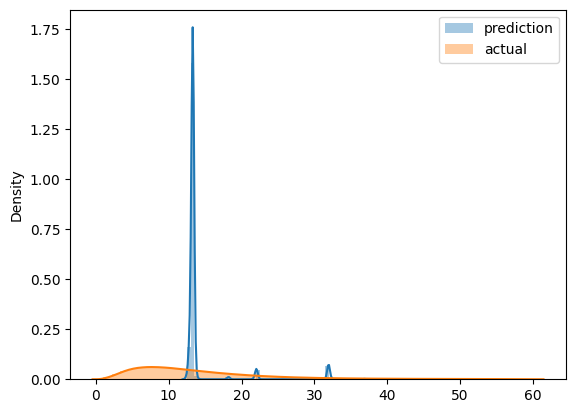

In [14]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [3]:
def read_dataframe(filename):
  if filename.endswith('.csv'):
    df = pd.read_csv(filename)

    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

  elif filename.endswith('.parquet'):
    df = pd.read_parquet(filename)

  df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
  df.duration = df.duration.apply(lambda td : td.total_seconds() / 60)

  df = df[(df.duration >= 1) & (df.duration <= 60)]

  categorical = ['PULocationID', 'DOLocationID']
  #numerical = ['trip_distance']
  df[categorical] = df[categorical].astype(str)

  return df

In [4]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet')
df_valid = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet')

In [17]:
len(df_train), len(df_valid)

(3403248, 3502516)

In [5]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_valid['PU_DO'] = df_valid['PULocationID'] + '_' + df_valid['DOLocationID']

In [ ]:
categorical = ['PU_DO'] #'PULocationID' , 'DOLocationID'
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

valid_dicts = df_valid[categorical + numerical].to_dict(orient='records')
X_valid = dv.fit_transform(valid_dicts)

feature_names = dv.get_feature_names_out()
X_valid = pd.DataFrame(X_valid.toarray(), columns=feature_names)

In [ ]:
target = 'duration'
y_train = df_train[target].values

y_valid = df_valid[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)

root_mean_squared_error(y_valid, y_pred)